## Imports

In [ ]:
from google.colab import drive
import os

import cv2
import matplotlib.pyplot as plt

import numpy as np
import random

## Data Description

**Cityscapes Image Pairs** <br>
*Semantic Segmentation for Improving Automated Driving*

Link: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

Download Kaggle Cityscape Dataset

In [ ]:
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# !kaggle datasets download -d dansbecker/cityscapes-image-pairs --unzip

## Data Loading

Mount Drive and SetUp Paths

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "enter path here.."

/content/drive/MyDrive/Indonesia AI/Computer Vision/Final Project


In [ ]:
main_dir = "enter path here.."
train_dir = os.path.join(main_dir, "train/")
val_dir = os.path.join(main_dir, "val/")

In [ ]:
print("Number of Images in Train Directory", len(os.listdir(train_dir)))
print("Number of Images in Test Directory", len(os.listdir(val_dir)))

Number of Images in Train Directory 2975
Number of Images in Test Directory 500


## Data Exploration

(256, 512, 3)


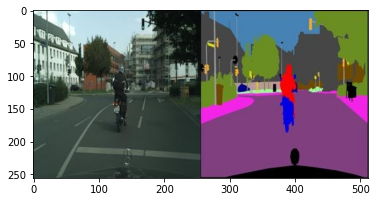

In [ ]:
index = random.randint(0, len(os.listdir(train_dir))-1)
sample_img = cv2.imread(os.path.join(train_dir, f"{index}.jpg"))
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB) #IMPORTANT
print(sample_img.shape)
plt.imshow(sample_img)

(256, 512, 3)


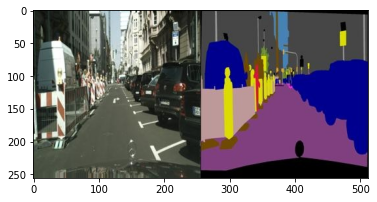

In [ ]:
index = random.randint(0, len(os.listdir(val_dir))-1)
sample_img = cv2.imread(os.path.join(val_dir, f"{index}.jpg"))
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB) #IMPORTANT
print(sample_img.shape)
plt.imshow(sample_img)

## Image Pre-Processing

One image contains both original and annotated image, so we need to split it

In [ ]:
def split_img(image):
  org_img = image[:, :256]
  anot_img = image[:, 256:]

  return org_img, anot_img

Original Image Dimensions:  (256, 256, 3)
Annotated Image Dimensions:  (256, 256, 3)


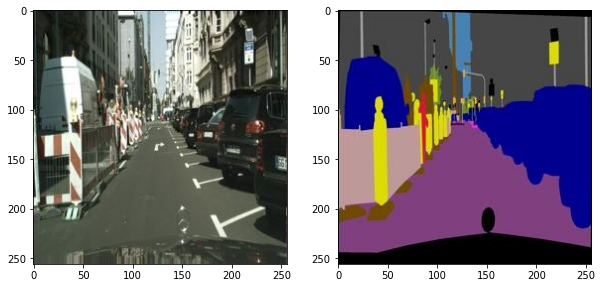

In [ ]:
org_img, anot_img = split_img(sample_img)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(org_img)
axes[1].imshow(anot_img)
print("Original Image Dimensions: ", org_img.shape)
print("Annotated Image Dimensions: ", anot_img.shape)

**Map to the Nearest Color**

We can observe there are lots of different colors in our annotated image, so we should map every pixel to the nearest color in our labeling keys.

In [ ]:
colors, counts = np.unique(anot_img.reshape(-1, 3), axis=0, return_counts=True)

In [ ]:
len(colors)

13574

This labeling key is taken from https://github.molgen.mpg.de/mohomran/cityscapes/blob/master/scripts/helpers/labels.py#L55


In [ ]:
class_map = {
    'unlabeled':(0, 0, 0),
    'sky':(70, 130, 180),
    'building':(70, 70, 70),
    'pole':(153, 153, 153),
    'road':(128, 64, 128),
    'sidewalk':(244, 35, 232),
    'vegetation':(107, 142, 35),
    'car':( 0, 0, 142),
    'person':(220, 20, 60),
    'traffic sign':(220, 220, 0)
}

In [ ]:
len(class_map)

10

There are 10 classes, of which 1 is for unlabelled, and the rest are unique objects in the image

**Generate Color Pallete**

The function below will map every pixel to the nearest color according to the color pallete.

In [ ]:
labels = list(class_map.keys())
unique_colors = list(class_map.values())

In [ ]:
### Initialization: Do just once
# Step 1: Define palette
palette = np.array(unique_colors)

# Step 2: Create/Load precalculated color cube
try:
    # for all colors (256*256*256) assign color from palette
    precalculated = np.load('view.npz')['color_cube']
except:
    precalculated = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculated[i,j,k] = palette[index]
    np.savez_compressed('view', color_cube = precalculated)

In [ ]:
# Processing part
#### Step 1: Take precalculated color cube for defined palette and 

def get_view(color_cube,image):
    shape = image.shape[0:2]
    indices = image.reshape(-1,3)
    # pass image colors and retrieve corresponding palette color
    new_image = color_cube[indices[:,0],indices[:,1],indices[:,2]]
   
    return new_image.reshape(shape[0],shape[1],3).astype(np.uint8)

map_img = get_view(precalculated, anot_img)

Text(0.5, 1.0, 'Mapped-to-Nearest-Color Image')

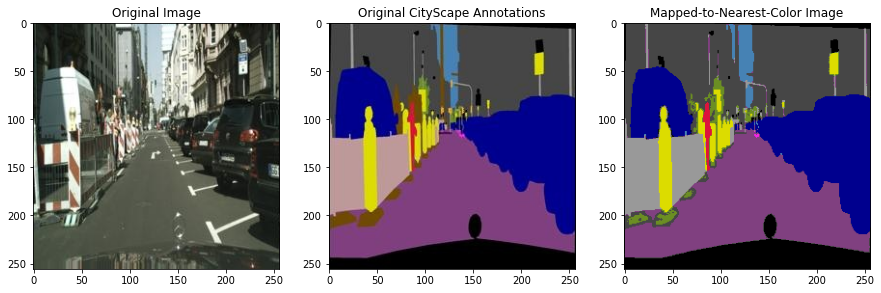

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

axes[0].imshow(org_img)
axes[0].set_title('Original Image')

axes[1].imshow(anot_img)
axes[1].set_title('Original CityScape Annotations')

axes[2].imshow(map_img)
axes[2].set_title('Mapped-to-Nearest-Color Image')

You can see that now the number of unique colors has been limited to the maximum of 10 classes.

In [ ]:
colors, counts = np.unique(map_img.reshape(-1, 3), axis=0, return_counts=True)

In [ ]:
len(colors)

10

**Encode the Labels from 0 to 9**

Now we need to loop through every pixel in the mapped image, and change its value to the index of that color in the unique colors list.

In [ ]:
encod_img = map_img.copy()
encod_img = encod_img.reshape(-1, 3)

In [ ]:
encod_img.shape

(65536, 3)

In [ ]:
for i in range(len(encod_img)):
  encod_img[i] = unique_colors.index(tuple(encod_img[i]))

In [ ]:
encod_img = encod_img.reshape(256, 256, 3)

In [ ]:
np.unique(encod_img)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

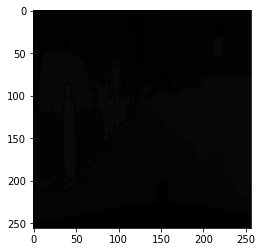

In [ ]:
plt.imshow(encod_img)

The diagram below summarizes the whole process.

Text(0.5, 1.0, 'Label-Encoded Image')

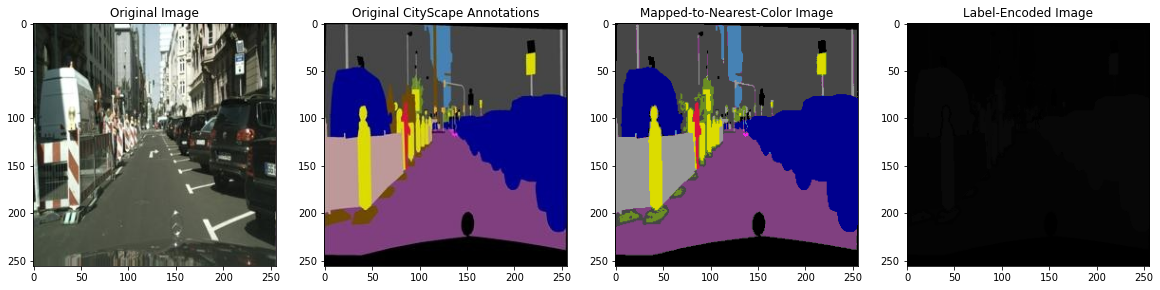

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20,5))

axes[0].imshow(org_img)
axes[0].set_title('Original Image')

axes[1].imshow(anot_img)
axes[1].set_title('Original CityScape Annotations')

axes[2].imshow(map_img)
axes[2].set_title('Mapped-to-Nearest-Color Image')

axes[3].imshow(encod_img)
axes[3].set_title('Label-Encoded Image')

**Image Pre-Processing Class**

This class combines the whole pre-processing steps together for train and val datasets.

In [ ]:
class process_images():
  def __init__(self, image_dir, data, samples):
    self.image_dir = image_dir
    self.samples = samples
    self.color_cube = np.load('view.npz')['color_cube']
    self.org_images = []
    self.anot_images = []

    self.main_dir = "/content/drive/MyDrive/Indonesia AI/Computer Vision/Final Project/Pre-Processed Dataset"
    if data == "train":
      self.org_imgpath = os.path.join(self.main_dir, "org_images_train")
      self.anot_imgpath = os.path.join(self.main_dir, "anot_images_train")
    elif data == "val":
      self.org_imgpath = os.path.join(self.main_dir, "org_images_val")
      self.anot_imgpath = os.path.join(self.main_dir, "anot_images_val")
  
  def pre_process(self):
    counter = 0
    for i in range(self.samples):
      counter += 1
      print(f"{counter} out of {self.samples}")

      img_name = f"{i+1}.jpg"
      img_path = os.path.join(self.image_dir, img_name)

      image = cv2.imread(img_path)
      org_img, anot_img = self.split_img(image)

      org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2GRAY) #We don't want color as a feature, so grayscale it.
      cv2.imwrite(os.path.join(self.org_imgpath, img_name), org_img)
      self.org_images.append(org_img)

      anot_img = cv2.cvtColor(anot_img, cv2.COLOR_BGR2RGB)
      map_img = self.map_nearest_color(anot_img)
      encod_img = self.label_encoder(map_img)

      path = os.path.join(self.anot_imgpath, f"{i+1}.npy")
      np.save(path, encod_img)
      self.anot_images.append(encod_img)

    return np.array(self.org_images), np.array(self.anot_images)

  def label_encoder(self, map_img):
    encod_img = map_img.copy()
    encod_img = encod_img.reshape(-1, 3)

    for i in range(len(encod_img)):
      encod_img[i] = unique_colors.index(tuple(encod_img[i]))

    encod_img = encod_img[:,1]
    
    encod_img = encod_img.reshape(256, 256)
    return encod_img

  def map_nearest_color(self, anot_img):
    shape = anot_img.shape[0:2]
    indices = anot_img.reshape(-1,3)
    
    new_image = self.color_cube[indices[:,0],indices[:,1],indices[:,2]]
   
    return new_image.reshape(shape[0],shape[1],3).astype(np.uint8)

  def split_img(self, image):
    org_img = image[:, :256]
    anot_img = image[:, 256:]

    return org_img, anot_img


*Only run the two code blocks below once, the next time just load the processed images from google drive folders.*

In [ ]:
# train_dataset = process_images(train_dir, "train", 1500)
# x_train, y_train = train_dataset.pre_process()

In [ ]:
# val_dataset = process_images(val_dir, "val", 350)
# x_test, y_test = val_dataset.pre_process()